In [1]:
#increase the display size to 95% of window width
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:95% !important; }</style>"))

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.axisartist
import scipy as sp
import glob

from matplotlib.ticker import FormatStrFormatter
from shutil import copyfile
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

%matplotlib inline
path = os.getcwd().split('/')

machine_path = '/' + path[1] + '/' + path[2]

plt.style.use(machine_path+'/Doutorado/cenarios/mandyoc/scripts/des.mplstyle')

In [2]:
def read_params(fpath):
    '''
    Read Nx, Nz, Lx, Lz from param.txt
    '''
    with open(fpath+"param.txt","r") as f:
        line = f.readline()
        line = line.split() #split by space a string to a list of strings
        Nx = int(line[-1])
        
        line = f.readline()
        line = line.split()
        Nz = int(line[-1])

        line = f.readline()
        line = line.split()
        Lx = float(line[-1])

        line = f.readline()
        line = line.split()
        Lz = float(line[-1])

    return Nx, Nz, Lx, Lz

def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

def read_density(fpath, step, Nx, Nz):
    '''
    Read density data from density_step.txt to extract interfaces
    '''

    Rho = np.loadtxt(fpath+"density_"+str(step)+".txt",skiprows=2, unpack=True, comments="P")
    Rho = np.reshape(Rho, (Nz, Nx))

    return Rho

def read_data(prop, step, Nz, Nx, fpath):
    '''
    Read and process data according to parameters
    '''
    
    #build filename
    filename = fpath + prop + "_" + str(step) + ".txt"

    data = np.loadtxt(filename, skiprows=2, unpack=True, comments="P")
    data = np.reshape(data, (Nz, Nx))
    
    return data

def extract_interface(z, Z, Nx, Datai, interface):
    #Extract the depth of a given interface 
    topo_aux = []

    for j in np.arange(Nx):
        topoi = interp1d(z, Datai[:,j])
        idx = (np.abs(topoi(Z)-interface)).argmin()
        topo = Z[idx]
        topo_aux = np.append(topo_aux, topo)
        
    return topo_aux

In [4]:
# scenarios = ['stable_1Gyr_400ppe_10x10_c750_C01/']
# scenarios = ['stable_1Gyr_400ppe_10x10_C1/', 'stable_1Gyr_400ppe_10x10_C01/', 'stable_1Gyr_400ppe_10x10_c750_C01/',
#             'stable_1Gyr_400ppe_10x10_c750_C1/', 'stable_rheol19_1Gyr_400ppe_10x10_c_1250_C1/',
#             'stable_PT200_rheo19_c1250_C1', 'stable_PT100_rheo19_c1250_C1/']

# scenarios = ['stable_PT100_rheol19_c1250_C1/']
# scenarios = ['stable_1Gyr_400ppe_10x10_c750_C01/']#'stable_1Gyr_400ppe_10x10_C1/']#, 'stable_1Gyr_400ppe_10x10_C01/', 'stable_1Gyr_400ppe_10x10_c750_C01/']
# scenarios = ['stable_PT200_rheol19_c1250_C1/']
# scenarios = ['stable_PT200_rheol19_075kappa_c1250_C1/']
# scenarios = ['stable_PT200_rheol19_c1250_C1_HprodAst/']
# scenarios = ['stable_PT400_rheol19_c1250_C1_HprodAst/']
# scenarios = ['stable_PT280_rheol19_c1250_C1_HprodAst/']
# scenarios = ['stable_PT290_rheol19_c1250_C1_HprodAst/']
# scenarios = ['stable_PT350_rheol19_c1250_C1_HprodAst/']
# scenarios = ['stable_PT200_keel_HprodAst/']
# scenarios = ['stable_DT200_rheol19_c1250_C1_HprodAst_Hlit150km/']
# scenarios = ['stable_DT290_rheol19_c1250_C1_HprodAst_Hlit150km/']
# scenarios = ['stable_DT350_rheol19_c1250_C1_HprodAst_Hlit150km/']
scenarios = ['stable_PT500_rheol19_c1250_C1_HprodAst_Hlit80km/']

prop = ['temperature']


for scenario in scenarios:
    print(scenario)
#     fpath = machine_path + '/Doutorado/cenarios/mandyoc/stable/lit80km/' + scenario
#     fpath = machine_path + '/Doutorado/cenarios/mandyoc/keel/' + scenario
    # fpath = machine_path + '/Doutorado/cenarios/mandyoc/stable/lit150km/' + scenario
    fpath = '/media/joao_macedo/Joao_Macedo/Doutorado/cenarios/mandyoc/stable/lit80km/' + scenario
    print(fpath)
    Nx, Nz, Lx, Lz = read_params(fpath)

    #Used to map interface
    z = np.linspace(Lz/1000.0, 0, Nz)
    Z = np.linspace(Lz/1000.0, 0, 8001) #zi
    #read time_*.txt files
    steps = sorted(glob.glob(fpath+"time_*.txt"), key=os.path.getmtime)
    step_initial = int(steps[0].split('/')[-1][5:-4])
    t0 = int(steps[0].split('/')[-1][5:-4])
    t1 = int(steps[1].split('/')[-1][5:-4])
    d_step = (t1 - t0)*1
    step_final = int(steps[-1].split('/')[-1][5:-4])
    nrows=len(range(step_initial, step_final+1, d_step))
    
#     mohos = []
#     labs = []
    times = []
    steps1 = []
    interfs = [] #list of interfaces to be mapped
    isots_evolution = []
    for step in range(step_initial, step_final+1, d_step):

        time_fname = fpath + 'time_' + str(step) + '.txt'
        time = np.loadtxt(time_fname, usecols=2, max_rows=1)
        time = round(time/1.0E6, 2)
        times.append(time)
        
        isots_evolution.append(time)
        isots_evolution.append(step)
        
        steps1.append(step)
        time = str(time)
    #     print(time, step)
        #read prop data
        Datai = read_data(prop[0], step, Nz, Nx, fpath)
        interfaces = [0, 500, 800, 1000, 1300, 1400, 1500, 1600, 1700] # Moho, LAB and other temperatures °C
        
        for interface in interfaces:
            interf = extract_interface(z, Z, Nx, Datai, interface)
            interf_mean = round(np.mean(interf), 2)
            interfs.append(interf_mean)
            isots_evolution.append(interf_mean)
            
            
        #extract interface depth
#         interf_moho = extract_interface(z, Z, Nx, Datai, interfaces[0])
#         interf_moho_mean = round(np.mean(interf_moho), 2)
#         mohos.append(interf_moho_mean)

#         interf_lab = extract_interface(z, Z, Nx, Datai, interfaces[1])
#         interf_lab_mean = round(np.mean(interf_lab), 2)
#         labs.append(interf_lab_mean)

        print(time, step)
    
    isots_evolution = np.asarray(isots_evolution)
    isots_evolution = isots_evolution.reshape(nrows, len(interfaces)+2)# +2 is to add step and time
#     isots_evolution = np.asarray([steps1, times, mohos, labs]).T
    
    np.savetxt(fpath + scenario[:-1:]+'_isotherms_evolution.txt', isots_evolution)

stable_DT200_rheol19_c1250_C1_HprodAst_Hlit150km/
/home/joao_macedo/Doutorado/cenarios/mandyoc/stable/lit150km/stable_DT200_rheol19_c1250_C1_HprodAst_Hlit150km/
0.0 0
2.5 500
5.0 1000
7.5 1500
10.0 2000
12.5 2500
15.0 3000
17.5 3500
20.0 4000
22.5 4500
25.0 5000
27.5 5500
30.0 6000
32.5 6500
35.0 7000
37.5 7500
40.0 8000
42.5 8500
45.0 9000
47.5 9500
50.0 10000
52.5 10500
55.0 11000
57.5 11500
60.0 12000
62.5 12500
65.0 13000
67.5 13500
70.0 14000
72.5 14500
75.0 15000
77.5 15500
80.0 16000
82.5 16500
85.0 17000
87.5 17500
90.0 18000
92.5 18500
95.0 19000
97.5 19500
100.0 20000
102.5 20500
105.0 21000
107.5 21500
110.0 22000
112.5 22500
115.0 23000
117.5 23500
120.0 24000
122.5 24500
125.0 25000
127.5 25500
130.0 26000
132.5 26500
135.0 27000
137.5 27500
140.0 28000
142.5 28500
145.0 29000
147.5 29500
150.0 30000
152.5 30500
155.0 31000
157.5 31500
160.0 32000
162.5 32500
165.0 33000
167.5 33500
170.0 34000
172.5 34500
175.0 35000
177.5 35500
180.0 36000
182.5 36500
185.0 37000
187.5 3

In [7]:
# steps

In [8]:
scenarios[0][:-1:]+'_isotherms_evolution.txt'

'stable_PT200_rheol19_c1250_C1_HprodAst_isotherms_evolution.txt'

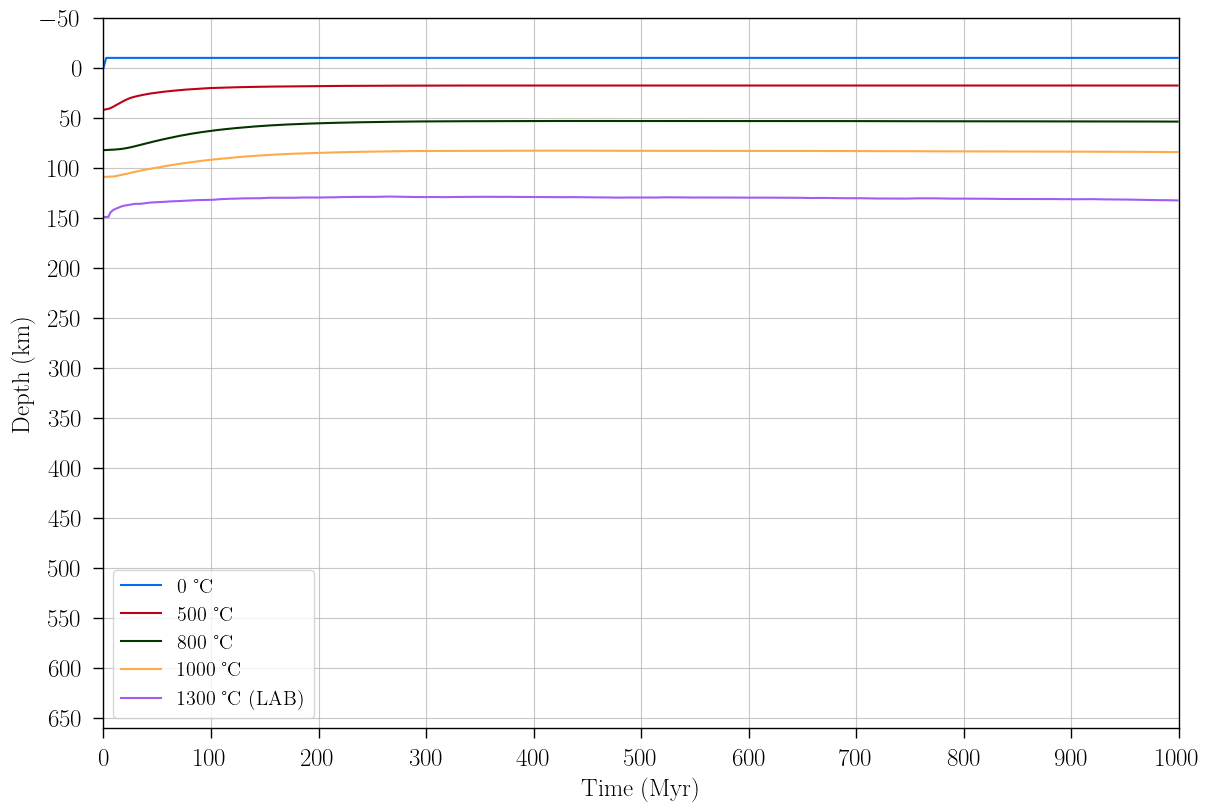

In [20]:
#Group 1 CLS - NoHprodAst
# scenarios = ['stable_rheol19_1Gyr_400ppe_10x10_c_1250_C1/']
# scenarios = ['stable_PT100_rheol19_c1250_C1/']
# scenarios = ['stable_PT200_rheol19_c1250_C1/']

#Group 2 CPE - HprodAst
#lit80km
# scenarios = ['stable_PT200_rheol19_c1250_C1_HprodAst/']
# scenarios = ['stable_PT280_rheol19_c1250_C1_HprodAst/']
# scenarios = ['stable_PT290_rheol19_c1250_C1_HprodAst/']
# scenarios = ['stable_PT350_rheol19_c1250_C1_HprodAst/']
# scenarios = ['stable_PT400_rheol19_c1250_C1_HprodAst/']

#lit150km
# scenarios = ['stable_DT200_rheol19_c1250_C1_HprodAst_Hlit150km/']
# scenarios = ['stable_DT290_rheol19_c1250_C1_HprodAst_Hlit150km/']
# scenarios = ['stable_DT350_rheol19_c1250_C1_HprodAst_Hlit150km/']

#keel
# scenarios = ['stable_PT200_keel_HprodAst/']

#plot data
label_fsize = 18
plt.rc('xtick', labelsize=label_fsize)
plt.rc('ytick', labelsize=label_fsize)

fig, ax = plt.subplots(1, 1, figsize=(12,8), sharex=True, sharey=True, constrained_layout=True)

#read_data
#time, step, 0, 500, 800, 1000, 1300, 1400, 1500, 1600, 1700
times, isot0, isot500, mohos, isot1000, labs = np.loadtxt('out/' + scenarios[0][:-1:]+'_isotherms_evolution.txt', unpack=True,
                                                          usecols=(0,2,3,4,5,6))

ax.plot(times, isot0-40, '-', label='0 °C')
ax.plot(times, isot500-40, '-', label='500 °C')
# ax.plot(times, mohos-40, '-', label='Moho (800 °C)')
ax.plot(times, mohos-40, '-', label='800 °C')
ax.plot(times, isot1000-40, '-', label='1000 °C')
ax.plot(times, labs-40, '-', label='1300 °C (LAB)')

#set plot details
ax.set_xlim([0,500])
ax.set_xticks(np.linspace(0,1000,11))
ax.set_yticks(np.linspace(-50,650,15))
ax.set_ylim([660, -50])
ax.grid(':k', alpha=0.7)
ax.set_xlabel('Time (Myr)', fontsize=label_fsize)
ax.set_ylabel('Depth (km)', fontsize=label_fsize)
ax.legend(loc='best')

figname = scenarios[0][:-1] + '_isotherm_evol'
fig.savefig('out/plots/' + figname+'.pdf', dpi=400)
fig.savefig('out/plots/' + figname+'.png', dpi=400)

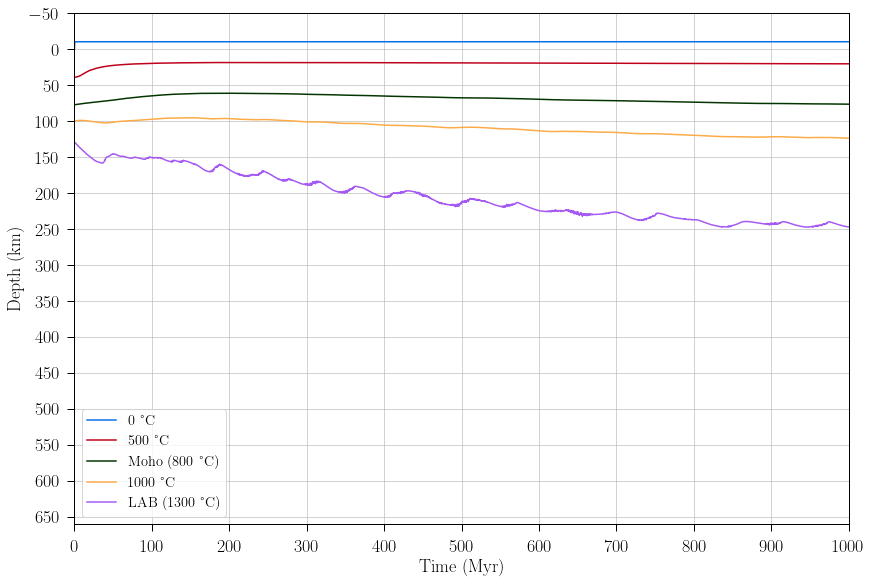

In [7]:
scenarios = ['stable_PT100_rheol19_c1250_C1/']

#plot data
label_fsize = 18
plt.rc('xtick', labelsize=label_fsize)
plt.rc('ytick', labelsize=label_fsize)

fig, ax = plt.subplots(1, 1, figsize=(12,8), sharex=True, sharey=True, constrained_layout=True)

#read_data
#time, step, 0, 500, 800, 1000, 1300, 1400, 1500, 1600, 1700
times, isot0, isot500, mohos, isot1000, labs = np.loadtxt('out/' + fpath+scenarios[0][:-1:]+'_isotherms_evolution.txt', unpack=True,
                                                          usecols=(0,2,3,4,5,6))

ax.plot(times, isot0-40, '-', label='0 °C')
ax.plot(times, isot500-40, '-', label='500 °C')
ax.plot(times, mohos-40, '-', label='Moho (800 °C)')
ax.plot(times, isot1000-40, '-', label='1000 °C')
ax.plot(times, labs-40, '-', label='LAB (1300 °C)')

#set plot details
ax.set_xlim([0,500])
ax.set_xticks(np.linspace(0,1000,11))
ax.set_yticks(np.linspace(-50,650,15))
ax.set_ylim([660, -50])
ax.grid(':k', alpha=0.7)
ax.set_xlabel('Time (Myr)', fontsize=label_fsize)
ax.set_ylabel('Depth (km)', fontsize=label_fsize)
ax.legend(loc='best')

In [10]:
len(times), len(isot0)

(2001, 2001)

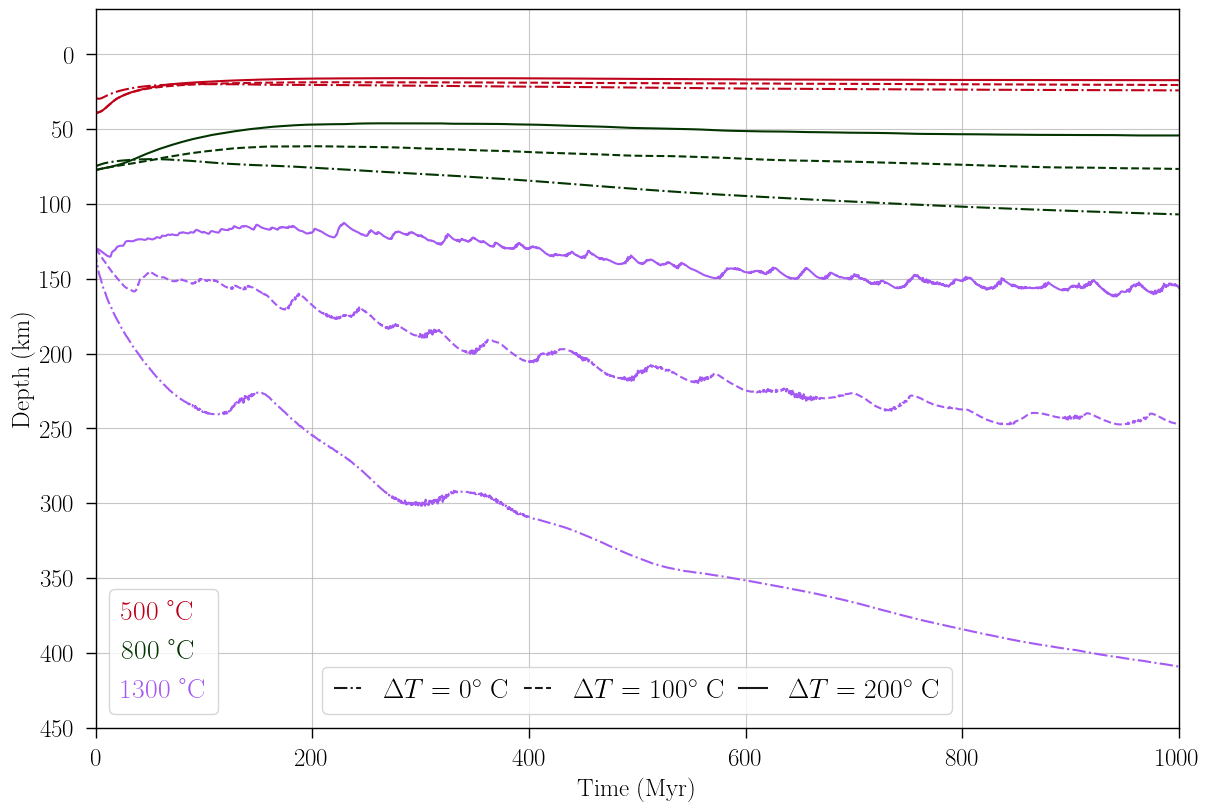

In [6]:
# scenarios = ['stable_1Gyr_400ppe_10x10_C1/',
#              'stable_1Gyr_400ppe_10x10_C01/',
#              'stable_1Gyr_400ppe_10x10_c750_C01/']


#No Heat production in asthenosphere
scenarios = ['stable_rheol19_1Gyr_400ppe_10x10_c_1250_C1/',
             'stable_PT100_rheol19_c1250_C1/',
             'stable_PT200_rheol19_c1250_C1/']

#With Heat production in asthenosphere
#hlit80km
# scenarios = ['stable_PT200_rheol19_c1250_C1_HprodAst/',
#              'stable_PT290_rheol19_c1250_C1_HprodAst/',
#              'stable_PT350_rheol19_c1250_C1_HprodAst/']
#hlit150km
# scenarios = ['stable_DT200_rheol19_c1250_C1_HprodAst_Hlit150km/',
#              'stable_DT290_rheol19_c1250_C1_HprodAst_Hlit150km/',
#              'stable_DT350_rheol19_c1250_C1_HprodAst_Hlit150km/']


lines = ['-.', '--', '-']

#No HprodAst
deltas = [r'$\Delta T = 0^{\circ}$ C',
          r'$\Delta T = 100^{\circ}$ C',
          r'$\Delta T = 200^{\circ}$ C']

#HprodAst
# deltas = [r'$\Delta T = 200^{\circ}$ C',
#           r'$\Delta T = 290^{\circ}$ C',
#           r'$\Delta T = 350^{\circ}$ C']


#plot data
label_fsize = 18
plt.rc('xtick', labelsize=label_fsize)
plt.rc('ytick', labelsize=label_fsize)

plt.close()
fig, ax = plt.subplots(1, 1, figsize=(12,8), sharex=True, sharey=True, constrained_layout=True)

#read_data
isots = [#select isotherms to plot
            # '0',
            '500',
            '800',
            # '1000',
            '1300']
    
for scenario, line in zip(scenarios, lines):
    times, isot0, isot500, isot800, isot1000, isot1300 = np.loadtxt('out/' + scenario[:-1:]+'_isotherms_evolution.txt',
                                                                  unpack=True, usecols=(0,2,3,4,5,6))
    
    isotherms_dict = {
        '0':    {'data': isot0,
                 'label': '0 °C',
                 'color': 'xkcd:cerulean blue'},
    
        '500':  {'data': isot500,
                 'label': '500 °C',
                 'color': 'xkcd:scarlet'},
    
        '800':  {'data': isot800,
                 'label': '800 °C',
                 'color': 'xkcd:dark green'},
    
        '1000': {'data': isot1000,
                 'label': '1000 °C',
                 'color': 'xkcd:light orange'},
    
        '1300': {'data': isot1300,
                 'label': '1300 °C',
                 'color': 'xkcd:lighter purple'},
    }
    
    for isot in isots:
        data = isotherms_dict[isot]['data']
        color = isotherms_dict[isot]['color']
        ax.plot(times, data-40, line, color=color)
        
#         ax.plot(times, mohos, '-', label='Moho (800 °C)')
#         ax.plot(times, labs, '-', label='LAB (1300 °C)')

#set plot details

ax.set_xlim([0,1000])
ax.set_ylim([450, -30])

nxticks=6
ax.set_xticks(np.linspace(0, 1000, nxticks))
nyticks=11
ax.set_yticks(np.linspace(450, 0, nyticks-1))

ax.grid(':k', alpha=0.7)
ax.set_xlabel('Time (Myr)', fontsize=label_fsize)
ax.set_ylabel('Depth (km)', fontsize=label_fsize)

for isot in isots:
    color = isotherms_dict[isot]['color']
    label  = isotherms_dict[isot]['label']
    ax.plot(-2, -2, mfc=color, color=color, alpha=0.9, label=label)
    
leg1 = ax.legend(loc='lower left', handlelength=0, handletextpad=0, ncol=1, fontsize=20)

for i, isot in zip(range(len(isots)), isots):
    color = isotherms_dict[isot]['color']
    leg1.get_texts()[i].set_color(color)
    
    
ax1 = ax.twinx()
ax1.axis('off')

for line, delta in zip(lines, deltas):
    ax1.plot([-2, -2],[-2, -2], line, color='black', alpha=0.9, label=delta)

leg1 = ax1.legend(loc='lower center', ncol=3, fontsize=20, columnspacing=0.5, handlelength=1)


figname = 'isototherm_evolution_DTs_NoHprodAst_hlit80km'
# figname = 'isototherm_evolution_DTs_HprodAst_hlit80km'
# figname = 'isototherm_evolution_DTs_HprodAst_hlit150km'


fig.savefig('out/plots/' + figname +'.pdf', dpi=400)
fig.savefig('out/plots/' + figname +'.png', dpi=400)

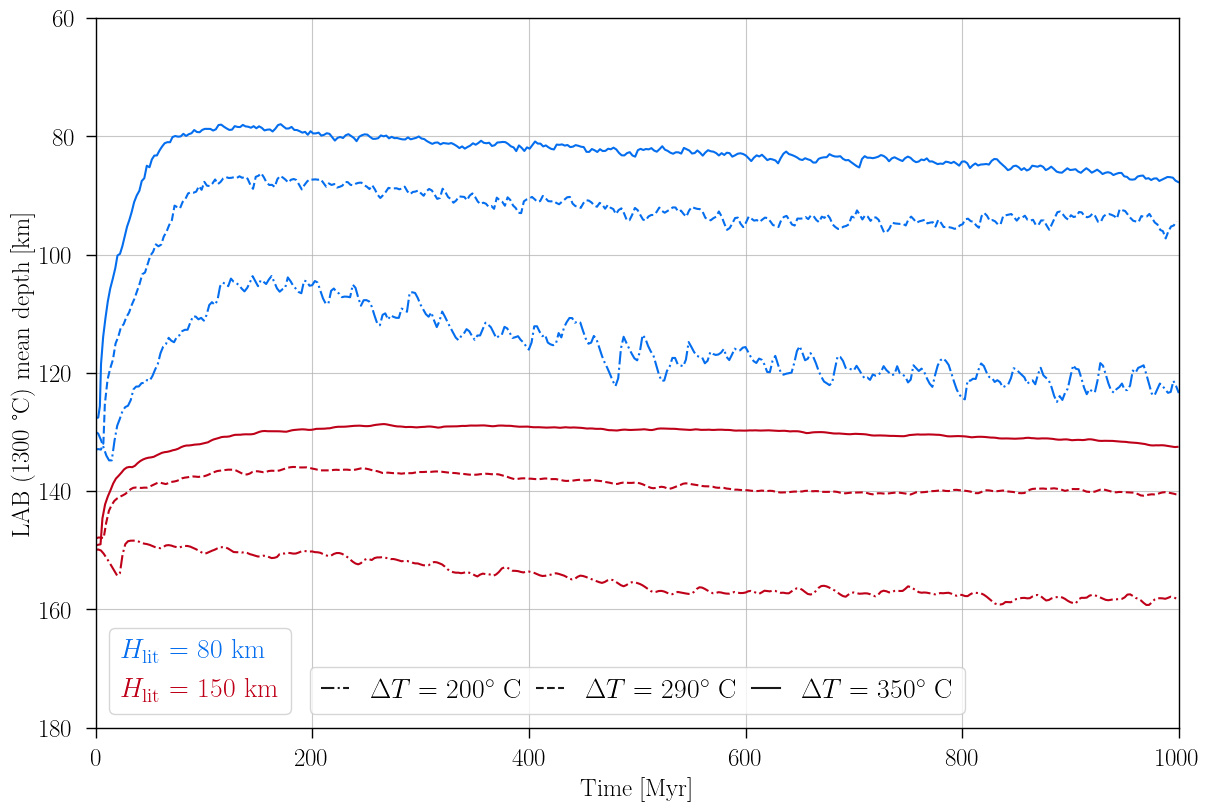

In [29]:
#With Heat production in asthenosphere
#hlit80km
scenarios = ['stable_PT200_rheol19_c1250_C1_HprodAst/',
             'stable_PT290_rheol19_c1250_C1_HprodAst/',
             'stable_PT350_rheol19_c1250_C1_HprodAst/',
             'stable_DT200_rheol19_c1250_C1_HprodAst_Hlit150km/',
             'stable_DT290_rheol19_c1250_C1_HprodAst_Hlit150km/',
             'stable_DT350_rheol19_c1250_C1_HprodAst_Hlit150km/']

lines = ['-.', '--', '-',
        '-.', '--', '-']

colors = ['xkcd:cerulean blue', 'xkcd:cerulean blue' , 'xkcd:cerulean blue',
          'xkcd:scarlet', 'xkcd:scarlet', 'xkcd:scarlet']

# HprodAst
deltas = [r'$\Delta T = 200^{\circ}$ C',
          r'$\Delta T = 290^{\circ}$ C',
          r'$\Delta T = 350^{\circ}$ C']


#plot data
label_fsize = 18
plt.rc('xtick', labelsize=label_fsize)
plt.rc('ytick', labelsize=label_fsize)

plt.close()
fig, ax = plt.subplots(1, 1, figsize=(12,8), sharex=True, sharey=True, constrained_layout=True)

#read_data
isots = [#select isotherms to plot
#             '0',
#             '500',
#             '800',
#             '1000',
            '1300']
    
for scenario, line, color in zip(scenarios, lines, colors):
    times, isot0, isot500, isot800, isot1000, isot1300 = np.loadtxt('out/' + scenario[:-1:]+'_isotherms_evolution.txt',
                                                                  unpack=True, usecols=(0,2,3,4,5,6))
    
    isotherms_dict = {
        '0':    {'data': isot0,
                 'label': '0 °C'},
    
        '500':  {'data': isot500,
                 'label': '500 °C'},
    
        '800':  {'data': isot800,
                 'label': '800 °C'},
    
        '1000': {'data': isot1000,
                 'label': '1000 °C'},
    
        '1300': {'data': isot1300,
                 'label': '1300 °C'},
    }
    
    for isot in isots:
        data = isotherms_dict[isot]['data']
        color = color
        ax.plot(times, data-40, line, color=color)
        
#         ax.plot(times, mohos, '-', label='Moho (800 °C)')
#         ax.plot(times, labs, '-', label='LAB (1300 °C)')

#set plot details

ax.set_xlim([0,1000])
ax.set_ylim([180, 60])

nxticks=6
ax.set_xticks(np.linspace(0, 1000, nxticks))
nyticks=11
# ax.set_yticks(np.linspace(200, 0, nyticks-1))

ax.grid(':k', alpha=0.7)
ax.set_xlabel('Time [Myr]', fontsize=label_fsize)
ax.set_ylabel('LAB (1300 °C) mean depth [km]', fontsize=label_fsize)

ax.plot(-2, -2, mfc=color, color='xkcd:cerulean blue', alpha=0.9, label=r'$H_{\mathrm{lit}}$ = 80 km')
ax.plot(-2, -2, mfc=color, color='xkcd:scarlet', alpha=0.9, label=r'$H_{\mathrm{lit}}$ = 150 km')

leg1 = ax.legend(loc='lower left', handlelength=0, handletextpad=0, ncol=1, fontsize=20)
leg1.get_texts()[0].set_color('xkcd:cerulean blue')
leg1.get_texts()[1].set_color('xkcd:scarlet')
    
    
ax1 = ax.twinx()
ax1.axis('off')

for line, delta in zip(lines[0:3], deltas):
    ax1.plot([-2, -2],[-2, -2], line, color='black', alpha=0.9, label=delta)

leg1 = ax1.legend(loc='lower center', ncol=3, fontsize=20, columnspacing=0.5, handlelength=1)


figname = 'isototherm_evolution_DTs_NoHprodAst_hlits'

fig.savefig('out/plots/' + figname +'.pdf', dpi=400)
fig.savefig('out/plots/' + figname +'.png', dpi=400)

In [ ]:
#With Heat production in asthenosphere
#hlit80km
scenarios = ['stable_PT0_rheol19_c1250_C1_HprodAst/',
             'stable_PT100_rheol19_c1250_C1_HprodAst/',
             'stable_PT200_rheol19_c1250_C1_HprodAst/']

lines = ['-.', '--', '-']

colors = ['xkcd:cerulean blue', 'xkcd:cerulean blue' , 'xkcd:cerulean blue',
          'xkcd:scarlet', 'xkcd:scarlet', 'xkcd:scarlet']

# HprodAst
deltas = [r'$\Delta T = 0^{\circ}$ C',
          r'$\Delta T = 100^{\circ}$ C',
          r'$\Delta T = 200^{\circ}$ C']


#plot data
label_fsize = 18
plt.rc('xtick', labelsize=label_fsize)
plt.rc('ytick', labelsize=label_fsize)

plt.close()
fig, ax = plt.subplots(1, 1, figsize=(12,8), sharex=True, sharey=True, constrained_layout=True)

#read_data
isots = [#select isotherms to plot
#             '0',
#             '500',
#             '800',
#             '1000',
            '1300']
    
for scenario, line, color in zip(scenarios, lines, colors):
    times, isot0, isot500, isot800, isot1000, isot1300 = np.loadtxt('out/' + scenario[:-1:]+'_isotherms_evolution.txt',
                                                                  unpack=True, usecols=(0,2,3,4,5,6))
    
    isotherms_dict = {
        '0':    {'data': isot0,
                 'label': '0 °C'},
    
        '500':  {'data': isot500,
                 'label': '500 °C'},
    
        '800':  {'data': isot800,
                 'label': '800 °C'},
    
        '1000': {'data': isot1000,
                 'label': '1000 °C'},
    
        '1300': {'data': isot1300,
                 'label': '1300 °C'},
    }
    
    for isot in isots:
        data = isotherms_dict[isot]['data']
        color = color
        ax.plot(times, data-40, line, color=color)
        
#         ax.plot(times, mohos, '-', label='Moho (800 °C)')
#         ax.plot(times, labs, '-', label='LAB (1300 °C)')

#set plot details

ax.set_xlim([0,1000])
ax.set_ylim([180, 60])

nxticks=6
ax.set_xticks(np.linspace(0, 1000, nxticks))
nyticks=11
# ax.set_yticks(np.linspace(200, 0, nyticks-1))

ax.grid(':k', alpha=0.7)
ax.set_xlabel('Time [Myr]', fontsize=label_fsize)
ax.set_ylabel('LAB (1300 °C) mean depth [km]', fontsize=label_fsize)

ax.plot(-2, -2, mfc=color, color='xkcd:cerulean blue', alpha=0.9, label=r'$H_{\mathrm{lit}}$ = 80 km')
ax.plot(-2, -2, mfc=color, color='xkcd:scarlet', alpha=0.9, label=r'$H_{\mathrm{lit}}$ = 150 km')

leg1 = ax.legend(loc='lower left', handlelength=0, handletextpad=0, ncol=1, fontsize=20)
leg1.get_texts()[0].set_color('xkcd:cerulean blue')
leg1.get_texts()[1].set_color('xkcd:scarlet')
    
    
ax1 = ax.twinx()
ax1.axis('off')

for line, delta in zip(lines[0:3], deltas):
    ax1.plot([-2, -2],[-2, -2], line, color='black', alpha=0.9, label=delta)

leg1 = ax1.legend(loc='lower center', ncol=3, fontsize=20, columnspacing=0.5, handlelength=1)


figname = 'isototherm_evolution_DTs_NoHprodAst_hlits'

fig.savefig('out/plots/' + figname +'.pdf', dpi=400)
fig.savefig('out/plots/' + figname +'.png', dpi=400)

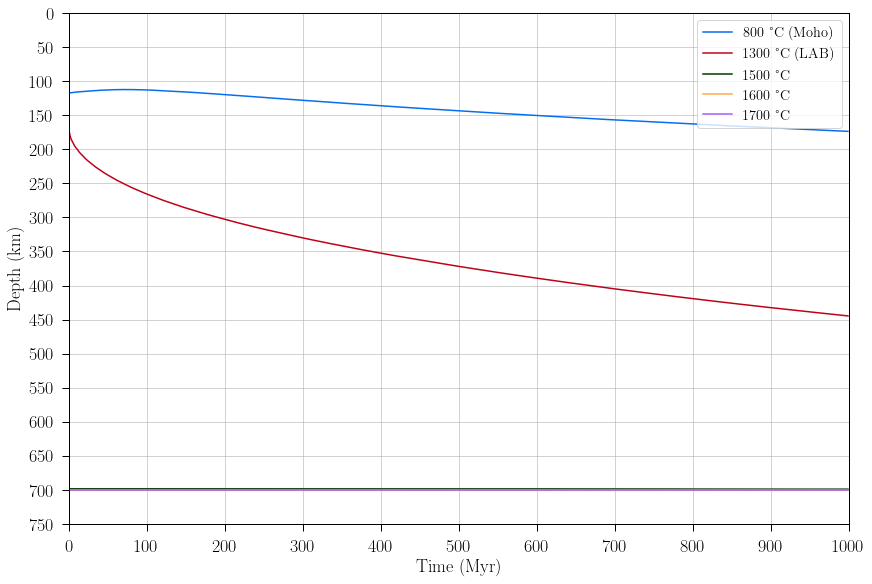

In [72]:
scenarios = ['stable_1Gyr_400ppe_10x10_C1/', 'stable_1Gyr_400ppe_10x10_C01/', 'stable_1Gyr_400ppe_10x10_c750_C01/']
#plot data
label_fsize = 18
plt.rc('xtick', labelsize=label_fsize)
plt.rc('ytick', labelsize=label_fsize)

fig, ax = plt.subplots(1, 1, figsize=(12,8), sharex=True, sharey=True, constrained_layout=True)

#read_data
times, mohos, labs, isot1500, isot1600, isot1700 = np.loadtxt('out/' + scenarios[0][:-1:]+'_isotherms_evolution.txt',
                                                                  unpack=True, usecols=(0,2,3,4,5,6))

ax.plot(times, mohos, '-', label='800 °C (Moho)')
ax.plot(times, labs, '-', label='1300 °C (LAB)')
ax.plot(times, isot1500, '-', label='1500 °C')
ax.plot(times, isot1600, '-', label='1600 °C')
ax.plot(times, isot1700, '-', label='1700 °C')

#set plot details
ax.set_xlim([0,1000])
ax.set_xticks(np.linspace(0,1000,11))
ax.set_yticks(np.linspace(0,750,16))
ax.set_ylim([750, 0])
ax.grid(':k', alpha=0.7)
ax.set_xlabel('Time (Myr)', fontsize=label_fsize)
ax.set_ylabel('Depth (km)', fontsize=label_fsize)
ax.legend(loc='upper right')